군집화 알고리즘
- 거리기반 : KMeans 사용
- 거리를 구해서 비슷한 내용들끼로 모아두는 것

<img src="https://av-eks-blogoptimized.s3.amazonaws.com/46668k-means-clustering-algorithm-in-machine-learning.png">


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans


from pecab import PeCab

In [3]:
# 음식 리뷰 예제 텍스트 데이터
corpus = [
    "샐러드 맛이 깔끔해서 좋아요.",
    "주문한 음식이 늦게 와서 배고팠어요.",
    "피자가 맛있어요.",
    "라면이 너무 짜게 나왔어요.",
    "배달된 치킨이 맛있어요.",
    "메뉴 설명보다 양이 적어요.",
    "주문한 음식이 다른 것으로 와서 다시 주문했어요.",
    "맛은 좋은데 양이 좀 적은 편이에요.",
    "떡볶이의 매운맛이 적절해요.",
    "초밥이 신선해서 좋았어요.",
    "빵이 부드럽고 맛있네요!",
    "스테이크가 너무 질겼어요.",
    "샐러드의 드레싱이 너무 강했어요.",
    "나초의 치즈소스가 맛있었어요.",
    "파스타가 약간 덜 익은 것 같아요.",
    "커피가 너무 진해서 물을 더 추가했어요.",
    "디저트는 달지 않아서 좋았습니다.",
    "음료가 너무 달아서 다음엔 당도 조절할게요.",
    "피자 도우가 너무 두꺼워서 먹기 힘들었어요.",
    "햄버거의 빵이 너무 딱딱해요.",
    "감자튀김이 너무 기름져서 느끼했어요.",
    "치즈케이크가 아주 부드럽고 맛있어요."
]

## 전처리
### 형태소 분석기를 통한 조사 구두점 제거
* https://github.com/hyunwoongko/pecab
* 조사, 구두점 제거
* 품사태그표 :
    * https://konlpy.org/ko/v0.6.0/morph/
    * https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0

In [ ]:
# Pecab : 품사, 형태소 분석하는 도구
pecab = PeCab()

In [5]:
pecab.pos(corpus[-1])

[('치즈케이크', 'NNP'),
 ('가', 'JKS'),
 ('아주', 'MAG'),
 ('부드럽', 'VA'),
 ('고', 'EC'),
 ('맛있', 'VA'),
 ('어요', 'EF'),
 ('.', 'SF')]

In [ ]:
# 제거할 품사(조사) 작업하기

for text, pos in pecab.pos(corpus[-1]):
    # print(text, pos)
    if not pos.startswith("J"):
        print(text, pos)

치즈케이크 NNP
아주 MAG
부드럽 VA
고 EC
맛있 VA
어요 EF
. SF


In [10]:
# 위 개념을 적용한 함수 작성
# 조사와 구둣점(느낌표) 제거

# drop_space : 문자가 가지고 있는 공백 제거 유무
# False : 공백 제거하지 말기

corpus_pecab = []
for corpus_text in corpus:
    join_text = []
    for text, pos in pecab.pos(corpus_text, drop_space=False):
        if (not pos.startswith("J")) and (pos not in ['SF']):
            join_text.append(text)
    corpus_pecab.append("".join(join_text))

In [11]:
corpus_pecab

['샐러드 맛 깔끔해서 좋아요',
 '주문한 음식 늦게 와서 배고팠어요',
 '피자 맛있어요',
 '라면 너무 짜게 나왔어요',
 '배달된 치킨 맛있어요',
 '메뉴 설명 양 적어요',
 '주문한 음식 다른 것 와서 다시 주문했어요',
 '맛 좋은데 양 좀 적은 편이에요',
 '떡볶이 매운맛 적절해요',
 '초밥 신선해서 좋았어요',
 '빵 부드럽고 맛있네요',
 '스테이크 너무 질겼어요',
 '샐러드 드레싱 너무 강했어요',
 '나초 치즈소스 맛있었어요',
 '파스타 약간 덜 익은 것 같아요',
 '커피 너무 진해서 물 더 추가했어요',
 '디저트 달지 않아서 좋았습니다',
 '음료 너무 달아서 다음 당도 조절할게요',
 '피자 도우 너무 두꺼워서 먹기 힘들었어요',
 '햄버거 빵 너무 딱딱해요',
 '감자튀김 너무 기름져서 느끼했어요',
 '치즈케이크 아주 부드럽고 맛있어요']

In [14]:
# 단어 개수 세기
vect = CountVectorizer()
dtm = vect.fit_transform(corpus)
dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 90 stored elements and shape (22, 75)>

In [13]:
vect.get_feature_names_out()

array(['감자튀김이', '강했어요', '같아요', '것으로', '기름져서', '깔끔해서', '나왔어요', '나초의', '너무',
       '느끼했어요', '늦게', '다른', '다시', '다음엔', '달아서', '달지', '당도', '도우가', '두꺼워서',
       '드레싱이', '디저트는', '딱딱해요', '떡볶이의', '라면이', '맛은', '맛이', '맛있네요', '맛있어요',
       '맛있었어요', '매운맛이', '먹기', '메뉴', '물을', '배고팠어요', '배달된', '부드럽고', '빵이',
       '샐러드', '샐러드의', '설명보다', '스테이크가', '신선해서', '아주', '않아서', '약간', '양이',
       '와서', '음료가', '음식이', '익은', '적어요', '적은', '적절해요', '조절할게요', '좋아요',
       '좋았습니다', '좋았어요', '좋은데', '주문한', '주문했어요', '진해서', '질겼어요', '짜게', '초밥이',
       '추가했어요', '치즈소스가', '치즈케이크가', '치킨이', '커피가', '파스타가', '편이에요', '피자',
       '피자가', '햄버거의', '힘들었어요'], dtype=object)

In [15]:
# 조사, 마침표 제거 후

vect = CountVectorizer()
dtm = vect.fit_transform(corpus_pecab)
dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 82 stored elements and shape (22, 67)>

In [16]:
vect.get_feature_names_out()

array(['감자튀김', '강했어요', '같아요', '기름져서', '깔끔해서', '나왔어요', '나초', '너무', '느끼했어요',
       '늦게', '다른', '다시', '다음', '달아서', '달지', '당도', '도우', '두꺼워서', '드레싱',
       '디저트', '딱딱해요', '떡볶이', '라면', '맛있네요', '맛있어요', '맛있었어요', '매운맛', '먹기',
       '메뉴', '배고팠어요', '배달된', '부드럽고', '샐러드', '설명', '스테이크', '신선해서', '아주',
       '않아서', '약간', '와서', '음료', '음식', '익은', '적어요', '적은', '적절해요', '조절할게요',
       '좋아요', '좋았습니다', '좋았어요', '좋은데', '주문한', '주문했어요', '진해서', '질겼어요', '짜게',
       '초밥', '추가했어요', '치즈소스', '치즈케이크', '치킨', '커피', '파스타', '편이에요', '피자',
       '햄버거', '힘들었어요'], dtype=object)

## 군집화

* https://scikit-learn.org/stable/modules/clustering.html#k-means
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [17]:
# KMeans : 군집화에 유명한 알고리즘
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init="auto", random_state=42)
kmeans

,n_clusters,7
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [18]:
# kmeans 에게 학습시키기
# dtm : 조사, 마침표 제거한 dtm  가져왔음

clusters = kmeans.fit_predict(dtm)
clusters

array([0, 6, 5, 2, 5, 0, 6, 0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 4, 3, 2, 2, 1],
      dtype=int32)

In [19]:
df = pd.DataFrame()
df['corpus'] = corpus
df['label'] = kmeans.labels_ # clusters
df.sort_values('label')

,corpus,label
0,샐러드 맛이 깔끔해서 좋아요.,0
5,메뉴 설명보다 양이 적어요.,0
7,맛은 좋은데 양이 좀 적은 편이에요.,0
8,떡볶이의 매운맛이 적절해요.,0
13,나초의 치즈소스가 맛있었어요.,0
14,파스타가 약간 덜 익은 것 같아요.,0
9,초밥이 신선해서 좋았어요.,0
16,디저트는 달지 않아서 좋았습니다.,0
21,치즈케이크가 아주 부드럽고 맛있어요.,1
10,빵이 부드럽고 맛있네요!,1


In [20]:
df['label'].value_counts()

label
0    8
2    6
6    2
5    2
1    2
4    1
3    1
Name: count, dtype: int64

## 군집화 결과
* 같은 내용의 텍스트끼리 군집화가 되었는지 확인

In [22]:
# 군집화를 위해서는 각 단어의 차원을 축소해달라고 요청해야 함
# 차원축소

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='random')
tsne_result = tsne.fit_transform(dtm)
tsne_result

array([[   4.188286 ,  -10.158622 ],
       [  77.684906 ,  -36.07067  ],
       [ -12.257861 ,   26.010206 ],
       [   1.0236918,  -73.676186 ],
       [ -30.74778  ,   34.992954 ],
       [  11.872683 ,   83.10953  ],
       [  94.3268   ,  -25.531525 ],
       [ -29.736471 ,   71.659134 ],
       [ -30.989128 ,    3.4029253],
       [  -1.5270116,   52.867016 ],
       [  12.409884 ,   25.91033  ],
       [ -35.75526  ,  -42.17694  ],
       [  -2.3545961,  -37.949017 ],
       [  30.876421 ,   50.953278 ],
       [  67.58274  ,   41.74887  ],
       [ -56.008045 ,  -66.416756 ],
       [ -68.85703  ,   44.627445 ],
       [ -66.660805 ,  -26.641705 ],
       [-103.58565  ,  -51.62729  ],
       [ -25.77532  ,  -59.79594  ],
       [ -31.064966 ,  -89.61601  ],
       [  31.89356  ,   11.283192 ]], dtype=float32)

In [23]:
df_tsne = pd.DataFrame(tsne_result, columns=['x', 'y'])
df_tsne['corpus'] = corpus
df_tsne['label'] = kmeans.labels_
df_tsne

,x,y,corpus,label
0,4.188286,-10.158622,샐러드 맛이 깔끔해서 좋아요.,0
1,77.684906,-36.070671,주문한 음식이 늦게 와서 배고팠어요.,6
2,-12.257861,26.010206,피자가 맛있어요.,5
3,1.023692,-73.676186,라면이 너무 짜게 나왔어요.,2
4,-30.747780,34.992954,배달된 치킨이 맛있어요.,5
5,11.872683,83.109528,메뉴 설명보다 양이 적어요.,0
6,94.326797,-25.531525,주문한 음식이 다른 것으로 와서 다시 주문했어요.,6
7,-29.736471,71.659134,맛은 좋은데 양이 좀 적은 편이에요.,0
8,-30.989128,3.402925,떡볶이의 매운맛이 적절해요.,0
9,-1.527012,52.867016,초밥이 신선해서 좋았어요.,0


C:\Users\soldesk\AppData\Local\Temp\ipykernel_8612\1425480084.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_tsne, x='x', y='y', palette='Set1')


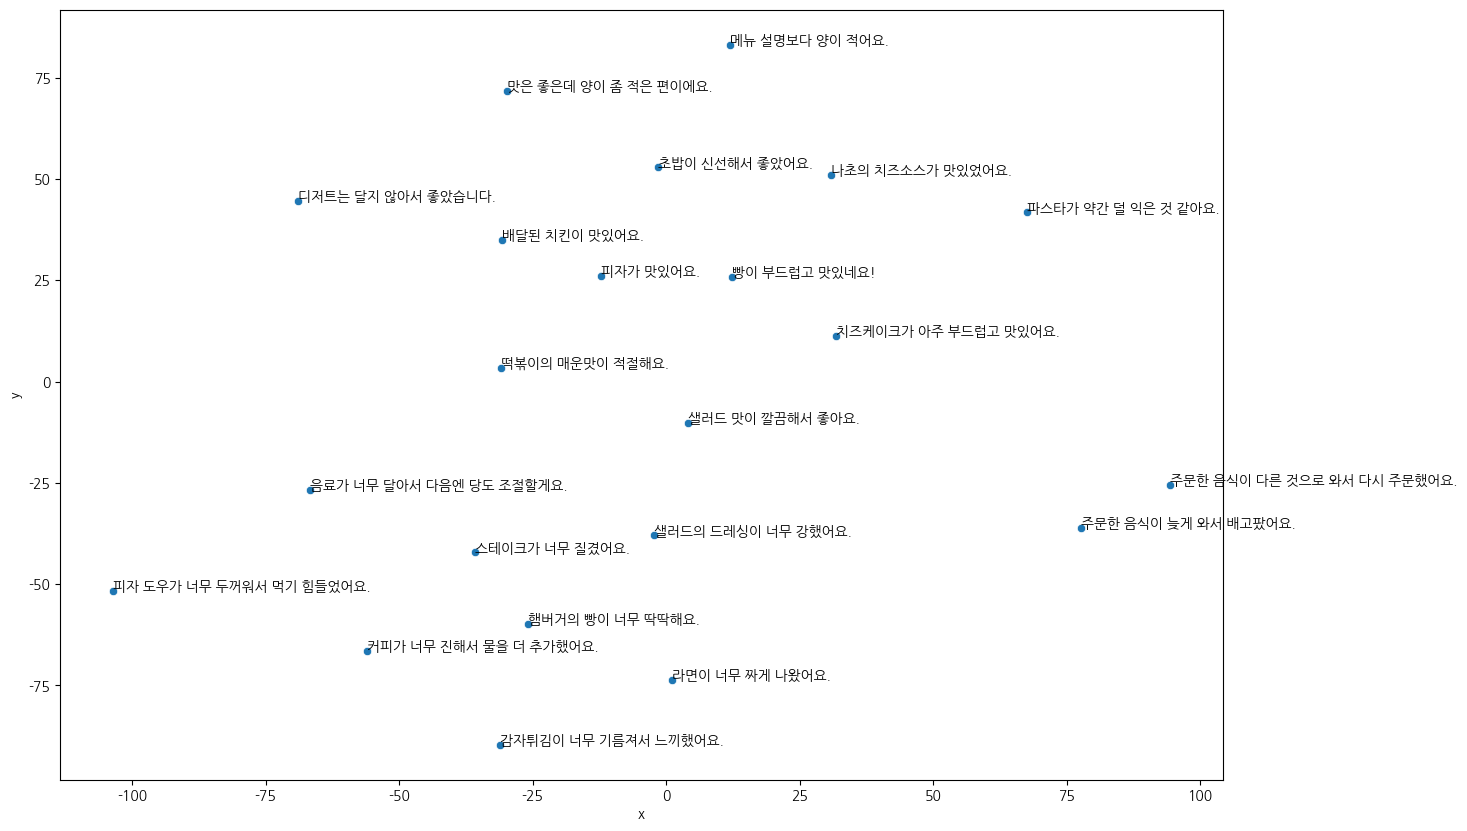

In [24]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_tsne, x='x', y='y', palette='Set1')
for i in df_tsne.index:
    plt.text(x=df_tsne.loc[i, 'x'], y=df_tsne.loc[i, 'y'], s=df_tsne.loc[i, 'corpus'])

### TfidfVectorizer

In [25]:
vect = TfidfVectorizer()
dtm = vect.fit_transform(corpus_pecab)
dtm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 82 stored elements and shape (22, 67)>

In [26]:
df_dtm = pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names_out())
df_dtm

,감자튀김,강했어요,같아요,기름져서,깔끔해서,나왔어요,나초,너무,느끼했어요,늦게,...,추가했어요,치즈소스,치즈케이크,치킨,커피,파스타,편이에요,피자,햄버거,힘들었어요
0,0.000000,0.000000,0.0,0.000000,0.599944,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.480298,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.741348,0.000000,0.00000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.549066,0.00000,0.309160,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.615711,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
5,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
7,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.57735,0.000000,0.000000,0.00000
8,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
9,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000


In [27]:
kmeans = KMeans(n_clusters=7, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(df_dtm)

In [28]:
df_tsne = pd.DataFrame()
df['corpus'] = corpus
df['label'] = kmeans.labels_
df.sort_values('label')

,corpus,label
8,떡볶이의 매운맛이 적절해요.,0
0,샐러드 맛이 깔끔해서 좋아요.,1
5,메뉴 설명보다 양이 적어요.,1
3,라면이 너무 짜게 나왔어요.,1
12,샐러드의 드레싱이 너무 강했어요.,1
11,스테이크가 너무 질겼어요.,1
9,초밥이 신선해서 좋았어요.,1
14,파스타가 약간 덜 익은 것 같아요.,1
15,커피가 너무 진해서 물을 더 추가했어요.,1
13,나초의 치즈소스가 맛있었어요.,1


In [29]:
tsne_result = tsne.fit_transform(df_dtm)

df_tsne = pd.DataFrame(tsne_result, columns=['x', 'y'])
df_tsne['corpus'] = corpus
df_tsne['label'] = kmeans.labels_
df_tsne

,x,y,corpus,label
0,49.168922,-37.549915,샐러드 맛이 깔끔해서 좋아요.,1
1,-35.910137,69.999016,주문한 음식이 늦게 와서 배고팠어요.,2
2,43.588818,15.770518,피자가 맛있어요.,5
3,-30.093285,-40.849377,라면이 너무 짜게 나왔어요.,1
4,47.292713,33.822601,배달된 치킨이 맛있어요.,5
5,-20.599325,30.693373,메뉴 설명보다 양이 적어요.,1
6,-45.707432,58.281174,주문한 음식이 다른 것으로 와서 다시 주문했어요.,2
7,-31.763430,-2.116445,맛은 좋은데 양이 좀 적은 편이에요.,6
8,11.658265,32.897709,떡볶이의 매운맛이 적절해요.,0
9,29.515867,63.967606,초밥이 신선해서 좋았어요.,1


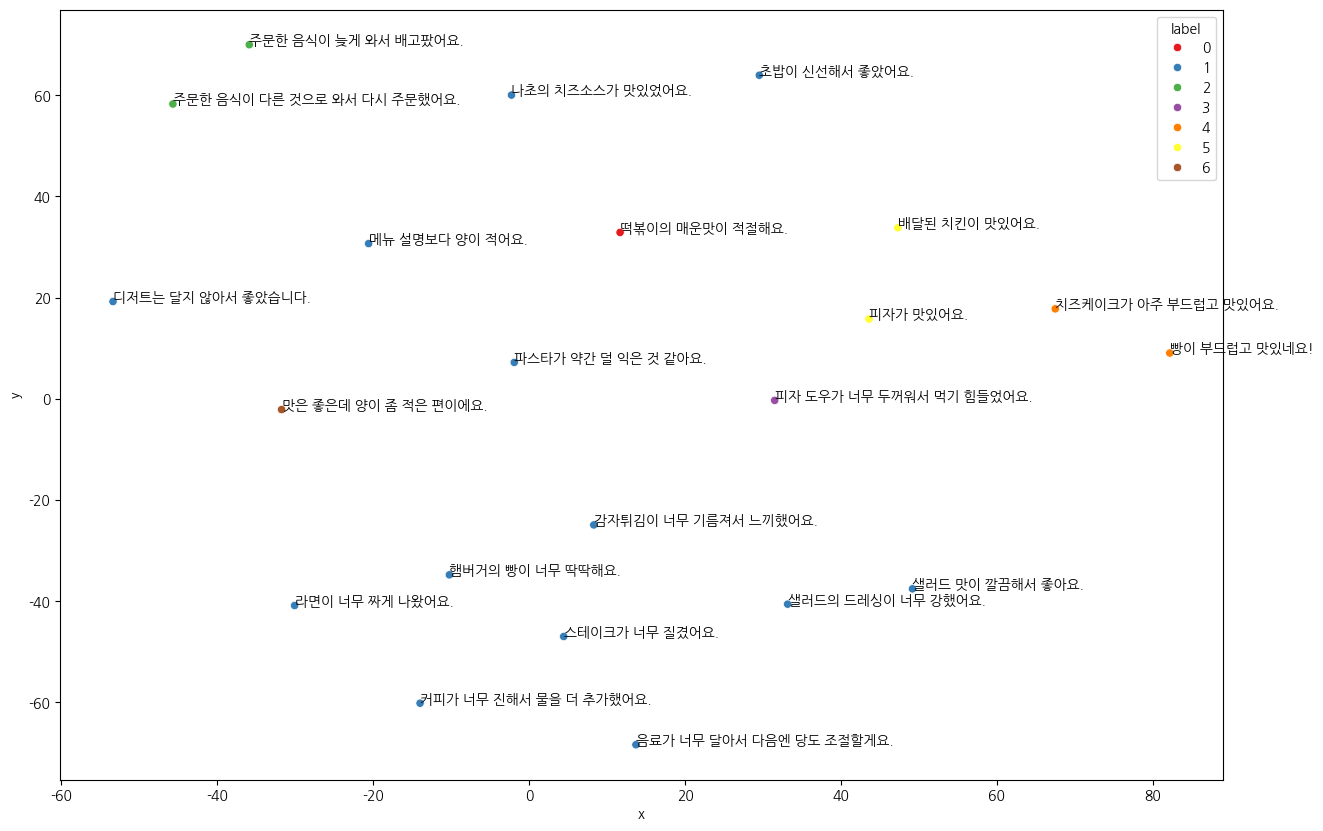

In [31]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', palette='Set1')
for i in df_tsne.index:
    plt.text(x=df_tsne.loc[i, 'x'], y=df_tsne.loc[i, 'y'], s=df_tsne.loc[i, 'corpus'])